In [2]:
with open("ResultsJson/LAST_smoothing_smoothing/1000.json") as json_data:
    data= json.load(json_data)
data.keys()

dict_keys(['preds', 'waypoint_preds', 'rotation', 'translation', 'csv_file', 'city', 'agent_labels', 'agent_features', 'social_features', 'social_label_features', 'att_weights'])

In [1]:
import numpy as np

# print(np.array(data["att_weights"]).shape)
# print(np.array(data["agent_labels"]).shape)
# print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)
# print(np.array(data["att_weights"]).shape)

In [2]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import json
import os
from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap() # 여기는 지도를 그리기 위한 API로 https://github.com/argoai/argoverse-api 를 참조하여 api를 설치하신 후에 사용 가능합니다.


In [71]:
import torch
import math
from shapely.geometry import LineString

def denormalization(arr, angle, translation_x, translation_y): # 테스트 결과근 normalize되서 나오므로 이를 다시 denormalization 시키는 코드

    theta = (angle)/180*math.pi
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    #rotate
    arr = np.array([R.dot(arr[...,:2][i].reshape((2,1))).flatten() for i in range(len(arr[...,:2]))])

    #translate
    arr[...,0] += translation_x
    arr[...,1] += translation_y
#     arr[...,0] += (AGENT[19,0] - AGENT[0,0])
#     arr[...,1] += (AGENT[19,1] - AGENT[0,1])
    return arr


def draw(AGENT, AVs, json_dict, graph_weight = None, head_num = 0, figsize = (8,8), Normalize = False, title = None, 
         draw_future = True, mode = "av2agent", gt = []):
    
    
    assert mode == "av2agent" or mode == "agent2av", "mode must be 'agent2av' or 'av2agent'"
    plt.ion()
    plt.figure(figsize=figsize)
    if title != None:
        plt.title(title)
    
    x_mean = np.array(json_dict['preds'])[0,:,0,0].mean()
    y_mean = np.array(json_dict['preds'])[0,:,0,1].mean()

    angle_ans = -json_dict['rotation']

    xmin, xmax, ymin,ymax = [9999], [-9999], [9999], [-9999]

    json_dict['preds'] = [[np.array(json_dict['preds'])[0][i] - json_dict['preds'][0][i][:1] for i in range(len(json_dict['preds'][0]))]]    # calculate x's mean and y's mean in predict
#     graph_weight = graph_weight[head_num]/ max(np.max(graph_weight[head_num]), 0.00001)
    graph_weight = graph_weight[head_num]
    if draw_future:
        for p in json_dict['preds'][0]:
            p = denormalization(np.array(p), angle_ans, -json_dict['translation'][0], -json_dict['translation'][1])
            p += AGENT[-1] - AGENT[0]
            plt.plot(p[...,0], p[...,1], linestyle='dashed', alpha = 0.5, zorder = -1)
            plt.scatter(p[...,0][-1], p[...,1][-1], linewidth=2, alpha = 0.5, zorder = -1)
            xmin, xmax = min(np.append(xmin, p[...,0])), max(np.append(xmax, p[...,0]))
            ymin, ymax = min(np.append(ymin, p[...,1])), max(np.append(ymax, p[...,1]))
        

    plt.plot(AGENT[...,0],AGENT[...,1], color='blue')
    plt.scatter(AGENT[...,0][-1],AGENT[...,1][-1], color='blue',linewidth=8)
    plt.scatter(AGENT[...,0][19],AGENT[...,1][19], color='blue')

#     print(graph_weight[3][0])
#     graph_weight[3][0] = graph_weight[3][0] / max(max(graph_weight[3][0]), 0.00001)
    if len(gt):
        plt.plot(gt[:, 0], gt[:, 1])
        plt.scatter(gt[:, 0][-1], gt[:, 1][-1], marker=(5, 1), color = 'red', s = 128, zorder = 0)
        

    for i, AV in enumerate(AVs):
        
        if AGENT[:,0][0] != AVs[i][:,0][0]: # 간혹 AV의 trajectory가 0으로 초기화 되어 있는 경우가 있는데 이 경우 AGENT의 초기값과 같아져 발생하는 오류때문에 넣어줌
            plt.plot(AV[...,0],AV[...,1], color='black')
            plt.scatter(AV[...,0][-1],AV[...,1][-1], color='black')
            if mode == "av2agent":
                plt.scatter(AV[...,0][-1],AV[...,1][-1], color='red', linewidth = 8, alpha = graph_weight[0][i+1])
            elif mode == "agent2av":
                plt.scatter(AV[...,0][-1],AV[...,1][-1], color='red', linewidth = 8, alpha = graph_weight[i+1][0])
            
            
            xmin = min(np.append(np.append(AGENT[...,0], AV[...,0]),xmin))
            xmax = max(np.append(np.append(AGENT[...,0], AV[...,0]),xmax))
            ymin = min(np.append(np.append(AGENT[...,1], AV[...,1]),ymin))
            ymax = max(np.append(np.append(AGENT[...,1], AV[...,1]),ymax))

    #draw map
#     print(graph_weight[head_num])
    local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
#     print(xmin, xmax, ymin, ymax)
    for l in local_lane_polygons:
        plt.plot(l[...,0],l[...,1], linewidth='0.5', color='gray')

    plt.savefig(f'ResultsImg/results_WIMP_attentinon2/{json_dict["csv_file"].split(".")[0]}_{head_num}.png')
#     plt.show()
    plt.close()


In [73]:
from tqdm.notebook import tqdm
import pickle 

root_dir = "ResultsJson/LAST_smoothing_smoothing/"  # Test결과 파일이 있는 위치
raw_data_dir = "./../WIMP/data/argoverse_processed_simple/val/" #argoverse rawdata(csv 파일)이 저장되어 있는 위치



file_list = sorted(os.listdir(raw_data_dir), key=lambda a : str(a.split('.')[0]))

for index in tqdm(range(len(file_list))): # 전체를 다 그리기는 힘드므로 일부만 시각화

    json_dict = {}

    with open(raw_data_dir + file_list[index], 'rb') as json_data:
        pickle_dict = pickle.load(json_data)

    with open(root_dir + file_list[index].split(".")[0] + ".json", 'r') as json_data:
        json_dict = json.load(json_data)
        

        
    rt = -json_dict["rotation"]
    tx = -json_dict["translation"][0]
    ty = -json_dict["translation"][1]

    social_features = [d["XY_FEATURES"] for d in pickle_dict["SOCIAL"]]
    
    AVs = np.array([denormalization(np.array(json_dict["social_features"][i]), rt, tx, ty) for i in range(len(json_dict["social_features"]))])
    AGENT = denormalization(np.array(pickle_dict["AGENT"]["XY_FEATURES"]), rt, tx, ty)
    graph_weight = np.array(json_dict["att_weights"])
    
    
    city_name = json_dict["city"]
#     AV = np.array(AV)
#     AGENT = np.array(AGENT)
    arr = pickle_dict['AGENT']['LABELS']
    angle =- json_dict['rotation']
    tx, ty = json_dict['translation']
    gt = denormalization(arr, angle, -tx, -ty)

    
    for i in range(1):
        # av2agent # agent 에게 영향을 주는 것
        draw(AGENT, AVs, json_dict, figsize=(15,15), Normalize = True, graph_weight=graph_weight, 
                         head_num = 3, mode = "av2agent", gt= gt) 
        break
    break

  0%|          | 0/39472 [00:00<?, ?it/s]

In [24]:
pickle_dict['AGENT']['LABELS']

array([[ 1.07933083e+01, -3.00130751e-02],
       [ 1.12015705e+01, -1.45823862e-02],
       [ 1.14279661e+01,  2.93002202e-04],
       [ 1.19084129e+01,  6.42824024e-02],
       [ 1.20530443e+01, -1.14045320e-02],
       [ 1.21454849e+01,  3.67873609e-02],
       [ 1.26491413e+01, -1.32305091e-02],
       [ 1.25108328e+01,  1.22964472e-01],
       [ 1.27680082e+01,  8.89535323e-02],
       [ 1.29510975e+01,  1.00496285e-01],
       [ 1.31719971e+01,  1.12159319e-01],
       [ 1.33833666e+01,  1.13748372e-01],
       [ 1.35149946e+01,  1.09324165e-01],
       [ 1.35960732e+01,  1.34754613e-01],
       [ 1.36978493e+01,  1.15643196e-01],
       [ 1.38920174e+01,  1.26861364e-01],
       [ 1.39784307e+01,  1.33724868e-01],
       [ 1.40143623e+01,  1.17423028e-01],
       [ 1.41312180e+01,  1.36831567e-01],
       [ 1.41184969e+01,  1.32280454e-01],
       [ 1.41625900e+01,  1.49113342e-01],
       [ 1.42239170e+01,  1.64394394e-01],
       [ 1.41896181e+01,  1.62575141e-01],
       [ 1.

In [25]:
pickle_dict.keys()

dict_keys(['AGENT', 'SOCIAL', 'PATH', 'SEQ_ID', 'TRANSLATION', 'ROTATION', 'CITY_NAME', 'TE'])

In [26]:
arr = pickle_dict['AGENT']['LABELS']
angle = pickle_dict['ROTATION']
tx, ty = pickle_dict['TRANSLATION']


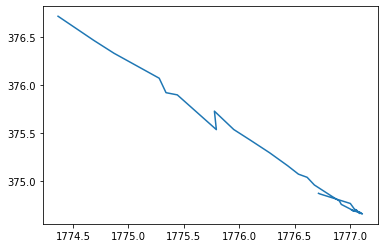

In [30]:
plt.plot(gt[:,0], gt[:,1])